# Zotero Retriever Tests

Helps you find literature in your Zotero library

In [31]:
# Settings

from dotenv import load_dotenv
import os

load_dotenv()
zotero_api_key = os.environ.get("ZOTERO_API_KEY_READ") # A Zotero API key, here sourced from .env - read only access is enough
zotero_library_id = os.environ.get("ZOTERO_TEST_GROUP_ID") # The library ID of the Zotero library to be accessed. Here a test group library
zotero_library_type = "group" # set the library type to either 'user' or 'group'. Make sure this corresponds to the library ID ('user' for your personal library)

zot_db = "./test_zotero_db" # directory to save the zotero vector store

reload_zotero = True # set to True to regenerate the zotero database

verbose = True # print additional information on routing decisions etc.

zotero_docs_returned = 10 # number of abstracts returned by the retriever

zotero_retriever_type = "mmr" # "similarity"  or "mmr"

add_tags = True # add tags to the abstract of the retrieved documents

embedding_model = "nomic-embed-text" # very good embedding model for retrieval tasks

# textgen model. generates answers to questions, with retrieved documents as context
# textgen_model = "llama3.2"
textgen_model = "o3-mini-2025-01-31"
# textgen_model = "phi4", # phi4 is a rather powerful model, but requires more gpu compute (that is, it will be slower than llama3.2 if not enough gpu memory is available)

# reasoning model. handles deciding whether or not to query the retriever
# reasoning_model = "nemotron-mini" # nvidia's nemotron-mini is smaller, but still capable of the simple reasoning task we need (retrieve or not)
# reasoning_model = "llama3.2" # fast, but not very good at reasoning tasks
reasoning_model = "o3-mini-2025-01-31"
# reasoning_model = "qwq" # qwq is a rather powerful experimental reasoning model. However, as it is rather large (20b), it either requires a fair bit of GPU memory or will be very slow 

# selfquery model. generates queries for the retriever
# selfquery_model = "phi4" # phi4 seems better at query construction than llama3.2, but requires more gpu compute (i.e. may be slower)
selfquery_model = "deepseek-r1:1.5b"

max_tokens = 2048 # maximum number of tokens to generate across models
temperature = 0 # temperature across models

In [32]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from pyzotero import zotero
from openai import OpenAI
from langchain_openai import ChatOpenAI

load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY")) # get API key from .env file

openai_models = [model.id for model in client.models.list()]

models = [textgen_model, reasoning_model, selfquery_model]
names = ["textgen_llm", "reasoning_llm", "selfquery_llm"]
for name, model in zip(names, models):
    if model in openai_models:
        if "o3" in model or o1 in model:
            print(f"Temperature parameter not supported for model {model}.")
            llm = ChatOpenAI(
                        model = model,
                        max_tokens = max_tokens, # max number of tokens to generate
                    )
        else:
            llm = ChatOpenAI(
                model = model,
                temperature=temperature,
                max_tokens = max_tokens, # max number of tokens to generate
            )
      
    else:
        llm = ChatOllama(
            model = model,
            temperature = temperature,
            num_predict = max_tokens, # max number of tokens to generate
        )
    globals()[f"{name}"] = llm

embeddings = OllamaEmbeddings(model = embedding_model)

zot = zotero.Zotero(zotero_library_id, zotero_library_type, zotero_api_key)

 ## pass settings for retriever (adjust as needed)
if zotero_retriever_type == "mmr":
    zot_search_type="mmr" # MMR (Maximal Marginal Relevance) aims to diversify search results. the amount of diversification is set via the lambda_mult parameter
    zot_search_kwargs={"k": zotero_docs_returned, # make sure the number of documents passed (k) fits into the context window
                    "fetch_k": zotero_docs_returned * 5, # could be adjusted, potentially run tests
                    "lambda_mult": 0.8} # amount of diversification, with 0 being maximum diversity
                   
if zotero_retriever_type == "similarity":
    zot_search_type="similarity" # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    zot_search_kwargs={"k": zotero_docs_returned} # make sure the number of documents passed (k) fits into the context window

Temperature parameter not supported for model o3-mini-2025-01-31.
Temperature parameter not supported for model o3-mini-2025-01-31.


### Turn Zotero Library into Vector Store Retriever

In [25]:
from langchain_core.documents import Document
from langchain_chroma import Chroma


if not os.path.exists(zot_db) or reload_zotero:

    lib = zot.everything(zot.top()) # note that "everything" includes items in the trash as well. However, double check if the API returned all entries

    docs = [
            Document(

                page_content= (
                    f"{entry.get('data').get('abstractNote')}\n\nTags: " 
                    + ", ".join(f"{tag.get('tag', '')}" for tag in entry.get("data", {}).get("tags", []))
                    if add_tags 
                    else entry.get("data").get("abstractNote")
                    ),
                    
                    metadata={
                        **{
                            "key": entry.get("key", ""), # unique identifier for the document
                            "version": entry.get("version", ""),
                            "abstractNote": entry.get("data").get("abstractNote", ""),
                            "itemType": entry.get("data").get("itemType", ""),
                            "tags": ", ".join(f"{tag.get('tag', '')}" for tag in entry.get("data", {}).get("tags", [])),
                        },
                        **(  
                            {
                                "authors": ", ".join(f"{creator.get('firstName', '')} {creator.get('lastName', '')}" for creator in entry.get("data", {}).get("creators", [])),
                            }
                            if any("firstName" in creator for creator in entry.get("data", "").get("creators", "")) or 
                            any("lastName" in creator for creator in entry.get("data", "").get("creators", "")) else
                            # note that the additional "name" passed here is in case the name is not split into first and last name
                            {
                                "authors": ", ".join(f"{creator.get('name', '')}" for creator in entry.get("data", {}).get("creators", [])),
                            }
                        ),
                        **(
                            {
                                "title": entry.get("data").get("caseName", ""),
                                "court": entry.get("data").get("court", ""),
                                "date": entry.get("data").get("dateDecided", ""),
                                "publication": entry.get("data").get("reporter", ""),
                                "volume": entry.get("data").get("reporterVolume", ""),
                                "pages": entry.get("data").get("firstPage", ""),
                            } # extra scheme for case law. Potentially add more schemes later, but the standard below should be sufficient for most documents
                            if entry.get("data", {}).get("itemType", "") == "case" else
                            {
                                "title": entry.get("data").get("title", ""),
                                "publication": entry.get("data").get("publicationTitle", ""),
                                "volume": entry.get("data").get("volume", ""),
                                "issue": entry.get("data").get("issue", ""),
                                "pages": entry.get("data").get("pages", ""),
                                "date": entry.get("data").get("date", ""),
                                "DOI": entry.get("data").get("DOI", ""),
                            }
                        ),
                        **(
                            {
                                "attachment_link": entry.get("links", "").get("attachment", "").get("href", ""),
                            }
                            if "attachment" in entry.get("links") else {}
                            
                        )
                        
                    },
                id = entry.get("key"), # note: when adding an ID, documents will be updated automatically (rather than producing duplicates!)
            )
            for entry in lib
        ]

    zot_store = Chroma(
            collection_name="lit_helper_zot_test",
            embedding_function=embeddings,
            persist_directory=zot_db,  # save data locally
            )
    
    zot_store.add_documents(docs)

else: 
    zot_store = Chroma(
            collection_name="lit_helper_zot_test",
            embedding_function=embeddings,
            persist_directory=zot_db,  # save data locally
            )


ConnectError: [WinError 10061] Es konnte keine Verbindung hergestellt werden, da der Zielcomputer die Verbindung verweigerte

In [ ]:
zot_store.get()

{'ids': ['NYMVCIWW',
  'SGBXG3VK',
  'ZLC5BFNZ',
  'TIBTPDYA',
  'Z6BBZCCD',
  'CMCSR8ZB',
  'RZU5JPPT',
  'U523J9EW',
  'MXP6T6Z5',
  'DWLVTEXY',
  'BE3K9ZUN',
  'ZI9RWDTP',
  '3QX98333',
  'LXYC3FRB',
  '4BUJAHRD',
  '7XQY6WAN',
  'NCVY6N6B',
  'SXY7BS8V',
  'G2XYFRM2',
  '3NYQDSD5',
  'K3Z3AA7G',
  '38MRDZIE',
  '8KR96M72',
  'AWKU6VLF',
  'TIZTE6KP',
  'GBL38GF5',
  'XZ8U8NDG',
  'HVAQRCGX',
  'Y4EWYD64',
  'MSN6EVBD',
  '4IHA9DB8',
  'N3E2VYYT',
  'TDJ3PPXT',
  '34B89RZ6',
  'XIIKEPPV',
  'APR9RZJS',
  '23LRALK2',
  'X43LNE4H',
  'CUXPF5PC',
  '7FB6FAPX',
  'BVIA4AJE',
  '2M8NBHVR'],
 'embeddings': None,
 'documents': ['Fake news has become an important topic of research in a variety of disciplines including linguistics and computer science. In this paper, we explain how the problem is approached from the perspective of natural language processing, with the goal of building a system to automatically detect misinformation in news. The main challenge in this line of research is coll

## Self-querying retriever

In [14]:
# make the retriever self-querying

from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.chains.query_constructor.base import get_query_constructor_prompt
from langchain.chains.query_constructor.base import StructuredQueryOutputParser
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_community.query_constructors.chroma import ChromaTranslator

zotero_metadata_info = [
    # note that the attribute infos can have a vast influence on the performance of the retriever (likely model dependant)
    #   The name seems to be most important when the model chooses the filter - with notable side effects for other attributes when changing the name of one!
    #   Beware that the names here need to correspond to the names in the metadata of the documents set above (changes in the name here require updating the chroma database)
    AttributeInfo(
        name = "authors",
        description="The paper authors' names, comma-seperated.",
        type="string",
    ),
    AttributeInfo(
        name = "title",
        description="The title of the document.",
        type="string",
    ),
    AttributeInfo(
        name = "tags",
        description="Tags associated with the document, comma-seperated.",
        type="string",
    ),
    AttributeInfo(
        name = "type",
        description="The type of document.",
        type="string",
    ),
    AttributeInfo(
        name = "publication",
        description="The publication the document was published in.",
        type="string",
    ),
    AttributeInfo(
        name = "volume",
        description="The volume of the publication.",
        type="string",
    ),
    AttributeInfo(
        name = "issue",
        description="The issue of the publication.",
        type="string",
    ),
    AttributeInfo(
        name = "pages",
        description="The pages of the publication.",
        type="string",
    ),
    AttributeInfo( 
        name = "date",
        description="The publication date.",
        type="string",
    ),
    AttributeInfo(
        name = "DOI",
        description="The DOI of the document.",
        type="string",
    ),
    AttributeInfo(
        name = "court",
        description="For law cases, court the case was decided in.",
        type="string",
    ),
]

zotero_abstract_description = "An abstract of the document."

allowed_comparators = [ # we need to fine tune these, otherwise the "contains" operator is used, which is not supported by Chroma
    "$eq",  # Equal to (number, string, boolean)
    "$ne",  # Not equal to (number, string, boolean)
    "$gt",  # Greater than (number)
    "$gte",  # Greater than or equal to (number)
    "$lt",  # Less than (number)
    "$lte",  # Less than or equal to (number)
]

retrieval_prompt = get_query_constructor_prompt( # we're using a premade prompt for the query constructor
    document_contents=zotero_abstract_description,
    attribute_info=zotero_metadata_info,
    allowed_comparators=allowed_comparators, 
    # examples = retriever examples, # we can optionally add examples for the model to fine tune the retrieval. See https://github.com/langchain-ai/langchain/blob/master/cookbook/self_query_hotel_search.ipynb
)

output_parser = StructuredQueryOutputParser.from_components( # we're also using a premade output parser
    fix_invalid=True, # this automatically fixes invalid queries (that is, it should avoid errors being thrown when the model constructs an invalid query)
    ) 

query_constructor = retrieval_prompt | selfquery_llm | output_parser # make the query constructor chain

zot_retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=zot_store,
    structured_query_translator=ChromaTranslator(), # we need to specify the translator for our database scheme, e.g. Chroma
    search_type=zot_search_type,
    search_kwargs=zot_search_kwargs, 
)

print(retrieval_prompt.format(query="{query}")) # print out the prompt used for the query constructor



Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` ($eq | $ne | $gt | $gte | $lt | $lte): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not): logical operator
- 

In [15]:
q = "Find texts about Amazon with the tag 'Surveillance'"

In [16]:
query_constructor.invoke(q)

StructuredQuery(query='text', filter=Operation(operator=<Operator.OR: 'or'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='title', value='Amazon'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='tag', value='Surveillance')]), limit=None)

In [17]:
zot_retriever.invoke(q)

OutputParserException: Parsing text
<think>
Okay, so I need to figure out how to structure this user query into a markdown code snippet that matches the given schema. Let me start by understanding what's being asked.

The user provided an example where they had a query and filter. In Example 1, the query was "teenager love" which refers to the genre part of the song lyrics. The filter included conditions on the artist, length, and genre. So, I need to break down the user's query into a similar structure.

The user's query is: "Find texts about Amazon with the tag 'Surveillance'". Let me parse this step by step.

First, the content is a song lyrics, so it's likely that the data source has attributes related to music or songs. The user wants to find texts (lyrics) about Amazon with a specific tag 'Surveillance'. 

Looking at the example, the query was "teenager love", which refers to the genre. So in this case, I think the query should be "surveillance" because that's what the user is looking for.

Now, the filter part: they want texts about Amazon and specifically with the tag 'Surveillance'. In Example 1, the filter included conditions on artist, length, and genre. But since the data source here doesn't have attributes like 'artist' or 'length', I need to think about what's relevant.

The user is looking for songs (lyrics) that are about Amazon. So perhaps there's an attribute called 'author' that includes names of authors associated with Amazon. Alternatively, maybe there's a tag or description that refers to Amazon. But in the example, they didn't have such attributes, so I might need to infer.

Wait, looking back at Example 3, which is about abstracts, it had an "author" field and other tags. So perhaps for this query, we can include 'author' as a possible attribute if it's present. But since the user didn't specify, maybe they just want all texts that mention 'Surveillance'.

So, putting it together: the query is "surveillance", and the filter includes conditions on the author being associated with Amazon and the tag being 'Surveillance'. 

But in Example 1, the attributes were 'artist', 'length', and 'genre'. Since this data source doesn't have those, maybe I should only include the necessary part. Alternatively, perhaps there's an attribute called 'author' that includes authors related to Amazon.

Wait, in Example 
 raised following error:
Got invalid JSON object. Error: Expecting value: line 1 column 1 (char 0)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [18]:
zot_store.similarity_search("", filter = {"title": "Big Data and quality data for fake news and misinformation detection"}, k = 5) # we can also directly search the database

[Document(metadata={'DOI': '10.1177/2053951719843310', 'abstractNote': 'Fake news has become an important topic of research in a variety of disciplines including linguistics and computer science. In this paper, we explain how the problem is approached from the perspective of natural language processing, with the goal of building a system to automatically detect misinformation in news. The main challenge in this line of research is collecting quality data, i.e., instances of fake and real news articles on a balanced distribution of topics. We review available datasets and introduce the MisInfoText repository as a contribution of our lab to the community. We make available the full text of the news articles, together with veracity labels previously assigned based on manual assessment of the articles’ truth content. We also perform a topic modelling experiment to elaborate on the gaps and sources of imbalance in currently available datasets to guide future efforts. We appeal to the commun

In [67]:
zot_store.get()

{'ids': ['a024ebf0-4026-48fc-b9fd-8b2af5557ece',
  'a456c9cb-f23d-41c0-93c7-691d5bdad6c8',
  'ebb08027-94a2-43e0-8675-40a92056ceef',
  '9abe5eae-0d5a-43a4-a1a1-dcc9733edcac',
  '46efc6e2-8f97-432c-8ad2-adc37e1410f1',
  '7d3f5f84-e17e-4db5-8055-8b005c2b6e5b',
  '4dd73010-7b30-4177-a2b7-33e1c1d308c5',
  '21f9cea2-d7f6-434f-a962-72252fe338b1',
  'b770ef65-85ee-4e3a-9ebb-d13cde98d982',
  'ecb0aef1-979b-4626-aeb4-83cf5d87b966',
  '98b11d6c-fdce-4d9e-a5b1-f06def316111',
  '343a2e41-1d20-4bee-91d3-c2f56ff0ca05',
  'a13b3bbd-db00-4409-bdd5-d81a6b0ab157',
  '9e7c73a9-3869-4547-9f0e-04c3136d0878',
  'd5451509-0656-4b35-8466-5adbdb1699df',
  '9ab41454-a6d2-4935-8725-362a76db9bad',
  '957553cc-39be-4660-928d-4bf2cd7fbd2d',
  '4918d9b9-39d4-4671-87e2-c13cfcadb3e6',
  '16e12de6-8f27-479b-9c7f-b43dc50f965f',
  'fd94969b-ebe3-455a-99df-9cd65a31d91e',
  '2f2a8d13-0fe1-438e-af16-86e5c7809773',
  '3ad87ad5-b72a-4730-a742-9ec2429f798b',
  '12acc8f2-8cfc-43af-9918-701580e96adc',
  '456634fa-926a-4b2d-a6b7-

Problem: we can only pass literal strings to the metadata field, e.g. the tags "Amazon" and "Surveillance" need to be concatenated to "Amazon, Surveillance", making filtering for either of them impossible (only the exact match would be returned). This is seemingly the case for all vector stores, as neither the `Document()` nor the `db.add_texts()` method allow lists to be passed as metadata. 
Solution: parse the tags at the end of the abstract in order to take advantage of the tagging by having the vector search pick up on them

Note: the same problem will occur with e.g. authors. Any multi-entry fields should be excluded from the self-query retriever schema. Only clear indicators (e.g. year, publication) should be included for the filtering. However, esp. authors should be returned in a structured output (hence should be kept as metadata). Check if a self querying retriever is still sufficiently useful and worth the computational overhead in this case

Possible alternative solution: partial string matching in the filtering, e.g. a filter operator capable of matching "Amazon" in "Amazon, Surveillance". This may require a different vector store db

Check if it is possible to build a retriever directly onto the Zotero API (without vector embeddings, and rather use zotero's built-in search) - this might circumvent these problems altogether (but potentially yields weaker results in the free form search)!

=> Check https://www.zotero.org/support/dev/client_coding/direct_sqlite_database_access, https://www.zotero.org/support/dev/web_api/v3/start (esp. searching) and LangChain community integrations (potentially contribute a custom integration?)

Alternatively (if abstract search via API sucks): parallel system were abstracts are retrieved and searched from a local vector store, and a tag/author search is provided via the zotero api? - documents could reliably be connected via zotero IDs

Note that building a retriever directly ontop of the Zotero API would require a custom scheme for querying in free text. That is, in order to make use of the filtering (which is the whole point!) we would have to write a robust prompt template / query generator for an LLM to make use of it

Alternative Solution 2: build 2 retrievers, one for tags, one for abstracts, and match them on their IDS. However, retrieving documents only on tags may be too broad and not yield good results

=> Zotero Retriever is working. Write Tests etc.; write prompting template for self-querying

=> Zotero API does not allow searching over abstracts. Build a second retriever with an abstract vector store, and make a retriever combining both results (metadata via self querying ZoteroRetriever, text search via a simple MMR AbstractRetriever)

In [9]:
test_doc = Document(page_content = "some text",
                        metadata={
        "title": "Surveillance and Amazon",
        "tags": ["Surveillance", "Amazon"]
    }
                    )

test_db = Chroma(collection_name="test", embedding_function=embeddings)

test_db.add_documents([test_doc])

ValueError: Expected metadata value to be a str, int, float or bool, got ['Surveillance', 'Amazon'] which is a list in upsert.

Try filtering complex metadata from the document using langchain_community.vectorstores.utils.filter_complex_metadata.

In [3]:
from pydantic import BaseModel, Field

zot_prompt = (
  "You are a helpful assistant for finding relevant scientific literature."
   "..."
)

# note that the generated answer is highly dependent on the system prompt, e.g. adding \n between the lines changes the output
#   (potentially depending on the model)

class literature(BaseModel):
        """Articles relevant to the question"""
        titles: List[str]
        # ...


## Non-self-querying

In [23]:
zot_retriever = zot_store.as_retriever(
    search_type=zot_search_type, 
    search_kwargs=zot_search_kwargs, 
)


In [24]:
from langchain_core.tools import tool

@tool
def zot_retrieve(query: str):
    """Search the zotero library for relevant scientific literature."""
    if query == "":
        return ""
    else:
        retrieved_docs = zot_retriever.invoke(query)
        serialized = "\n\n".join(
            (f"Title: {doc.metadata['title']}\n\nAuthors: {doc.metadata['authors']}\n\nAbstract: {doc.page_content}") 
            for doc in retrieved_docs
            )
        return serialized

In [25]:
system_prompt = (
  "You are a helpful assistant for finding relevant scientific literature."
   "You can use a zotero database to search for relevant literature."
   "When retrieving documents from the database, they will come with the attributes 'title' and 'authors'. Always report these."
   "If you cannot find any relevant literature, just say that no relevant literature is the the database, don't try to make up an answer."
)

In [26]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState # we're using the MessageState to represent the different parts of our agent in a conversation

# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([zot_retrieve])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}


# build retrieval tool as tool node (receives an AI message from query_or_respond)
tools = ToolNode([zot_retrieve])

# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

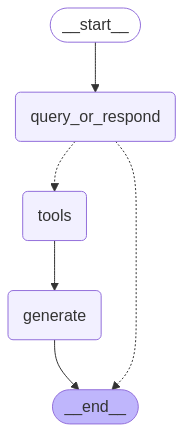

In [27]:
# set up the graph, including a conditional pass on the tools-based generation nodes

from langgraph.graph import END
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph # we're using the MessageState to represent the different parts of our agent in a conversation

tool_graph_builder = StateGraph(MessagesState)

tool_graph_builder.add_node(generate)

tool_graph_builder.add_node(query_or_respond)
tool_graph_builder.set_entry_point("query_or_respond")
tool_graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
tool_graph_builder.add_node(tools)
tool_graph_builder.add_edge("tools", "generate")

tool_graph_builder.add_edge("generate", END)

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
tool_graph = tool_graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test_thread"}}

display(Image(tool_graph.get_graph().draw_mermaid_png())) # show our graph architecture

In [28]:
input_message = "Hello" # whether or not the model correctly decides to use a tool is highly dependant on the model used; e.g gpt-4o is a lot better at this than llama3.2, qwq and nemotron-mini can handle this too

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [29]:
input_message = "Can you provide me with some literature on Amazon and surveillance?"

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you provide me with some literature on Amazon and surveillance?
================================== Ai Message ==================================
Tool Calls:
  zot_retrieve (call_QKu9uavMBJxvdOJS2glTwdp6)
 Call ID: call_QKu9uavMBJxvdOJS2glTwdp6
  Args:
    query: Amazon and surveillance literature


Number of requested results 50 is greater than number of elements in index 42, updating n_results = 42


================================= Tool Message =================================
Name: zot_retrieve

Title: Amazon: Surveillance as a Service

Authors: Emily West

Abstract: This essay argues that Amazon, the leading e-commerce platform in many parts of the world, uses surveillance not just as a key tool in the platform logic of its growing constellation of businesses but also increasingly as a service to its consumers. In contrast to prevailing assumptions that platforms will obscure the surveillant aspects of their businesses and that users will resist the intrusive nature of corporate surveillance, Amazon’s business practices point to the rapid normalization, and even embrace, of surveillant logics by consumers. Given the importance of consumer data to its operations, Amazon increasingly designs services whose purpose is, at least in part, to collect more data about consumers. The zenith of Amazon’s surveillance capabilities of its customers is no doubt its family of Echo devices en

**Note:** Depending on the model, the output can be prone to hallucinatins. Llama 3.2 is likely to fabulate literature, even when provided with adequate results from the retriever. ChatGPT o3-mini seems to not give a message by itself, only passing (?) the retriever results 

## Retrieval only - no Generation

We're using the Zotero Retriever written for Langchain Community to access literature via the Zotero API

In [5]:
import sys
sys.path.append("D:/academicCloud/Python Scripts/langchain-zotero-retriever/src")
from langchain_zotero_retriever.retrievers import ZoteroRetriever

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.environ.get("ZOTERO_API_KEY") # A Zotero API key, here sourced from .env - read only access is enough
library_id = os.environ.get("ZOTERO_TEST_GROUP_ID") # The library ID of the Zotero library to be accessed. Here a test group library
library_type = "group" # set the library type to either 'user' or 'group'. Make sure this corresponds to the library ID ('user' for your personal library)

retriever = ZoteroRetriever(api_key=api_key, library_id=library_id, library_type=library_type, type = "top", get_fulltext = False)


In [ ]:
# get tags used in the current library to pass to the function description/system prompt

from pyzotero import zotero

zot = zotero.Zotero(library_id, library_type, api_key)

library_tags = list(set(zot.tags())) # we use set() to remove any duplicates

In [ ]:
# get json schema from zotero to identify available item types and pass them to the function description
import json
import urllib.request

url = "https://raw.githubusercontent.com/zotero/zotero-schema/refs/heads/master/schema.json"
response = urllib.request.urlopen(url)
data = json.loads(response.read())

# get unique itemTypes from data
item_types = set()
for item in data["itemTypes"]:
    item_types.add(item["itemType"])

In [43]:
from typing import Optional, Union, List
from langchain_core.tools import tool
from langchain_core.tools import StructuredTool


def retrieve(query: str, 
             itemType: Optional[str], 
             tag: Optional[Union[str, List[str]]], 
             qmode: str = "everything", 
             since: Optional[int] = None):

    retrieved_docs = retriever.invoke(query, itemType = itemType, tag = tag, qmode = qmode, since = since)
    serialized_docs = "\n\n".join(
        (f"Metadata: { {key: doc.metadata[key] for key in doc.metadata if key != 'abstractNote'} }\n" f"Abstract: {doc.metadata['abstractNote']}\n")
        for doc in retrieved_docs
    )

    return serialized_docs, retrieved_docs

description = f"""Search and return relevant documents from a Zotero library. The following search parameters can be used:

    Args:
        query: str: The search query to be used. Try to keep this specific and short, e.g. a specific topic or author name
        itemType: Optional. Type of item to search for (e.g. "book" or "journalArticle"). Multiple types can be passed as a string seperated by "||", e.g. "book || journalArticle". Defaults to all types
        tag: Optional. For searching over tags attached to library items. If documents tagged with multiple tags are to be retrieved, pass them as a list. If documents with any of the tags are to be retrieved, pass them as a string separated by "||", e.g. "tag1 || tag2"
        qmode: Search mode to use. Changes what the query searches over. "everything" includes full-text content. "titleCreatorYear" to search over title, authors and year. Defaults to "everything"
        since: Return only objects modified after the specified library version. Defaults to return everything
    """

retriever_tool = StructuredTool.from_function(
    func=retrieve,
    name = "ZoteroLibrary",
    description = description,
    return_direct=True,
)

In [ ]:
# adding the tags and item types to the function description makes the description too long and can lead to API errors (e.g. with openAI)
# hence, we add them to the system prompt instead

## Note: the system prompt is currently not in use, it is kept here for future reference

system_prompt = (
  "You are a helpful assistant tasked with accessing relevant scientific literature."
   "You use a zotero database to search for relevant literature."
   "Your task is querying the database and passing the results to the user."
   f"When utilizing tags to search for documents, use this list of available tags: {library_tags}"
   "Do not use tags not provided in this list."
   f"When searching for specific item types, use this list of available types: {item_types}"
   "Only use the itemType parameter when the user asks for a specific type of document, and only use the types provided in the list."
   "If the database does not return any literature, try a different query. Never make up an answer."
)

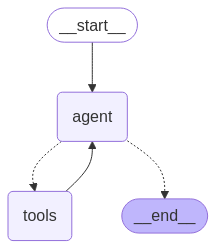

In [45]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

tool_node = ToolNode([retriever_tool])

model_with_tools = reasoning_llm.bind_tools([retriever_tool])


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test_thread"}}

display(Image(app.get_graph().draw_mermaid_png()))

In [46]:
input_message = "Can you provide me with some literature on Amazon and surveillance?"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you provide me with some literature on Amazon and surveillance?
================================== Ai Message ==================================
Tool Calls:
  ZoteroLibrary (call_I5BnAdbOActr9rfXjZAXEZob)
 Call ID: call_I5BnAdbOActr9rfXjZAXEZob
  Args:
    query: Amazon surveillance
    itemType: None
    tag: None
    qmode: everything
    since: None
================================= Tool Message =================================
Name: ZoteroLibrary

("Metadata: {'key': '3NYQDSD5', 'version': 33291, 'itemType': 'journalArticle', 'tags': 'Amazon, Artificial Intelligence, Digital Capitalism, Surveillance', 'authors': 'Emily West', 'title': 'Amazon: Surveillance as a Service', 'publication': 'Surveillance & Society', 'volume': '17', 'issue': '1/2', 'pages': '27-33', 'date': '2019/03/31', 'DOI': '10.24908/ss.v17i1/2.13008'}\nAbstract: This essay argues that Amazon, the leading e-commerce platform in man

In [47]:
input_message = "Can you provide me with some tagged with both 'digital capitalism' and 'surveillance'?"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you provide me with some tagged with both 'digital capitalism' and 'surveillance'?
================================== Ai Message ==================================
Tool Calls:
  ZoteroLibrary (call_f6REaKW6heJl97JFpD9QpPDd)
 Call ID: call_f6REaKW6heJl97JFpD9QpPDd
  Args:
    query: 
    itemType: None
    tag: ['digital capitalism', 'surveillance']
    qmode: everything
    since: None
================================= Tool Message =================================
Name: ZoteroLibrary

('Metadata: {\'key\': \'3NYQDSD5\', \'version\': 33291, \'itemType\': \'journalArticle\', \'tags\': \'Amazon, Artificial Intelligence, Digital Capitalism, Surveillance\', \'authors\': \'Emily West\', \'title\': \'Amazon: Surveillance as a Service\', \'publication\': \'Surveillance & Society\', \'volume\': \'17\', \'issue\': \'1/2\', \'pages\': \'27-33\', \'date\': \'2019/03/31\', \'DOI\': \'10.24908/ss.v17i1/2.13008\'}\

In [48]:
input_message = "I'm looking for some literature on either Habermas or Cybernetics"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

I'm looking for some literature on either Habermas or Cybernetics
================================== Ai Message ==================================
Tool Calls:
  ZoteroLibrary (call_CGXljSjOOn0TPWg3652VoRSU)
 Call ID: call_CGXljSjOOn0TPWg3652VoRSU
  Args:
    query: Habermas OR Cybernetics
    itemType: None
    tag: None
    qmode: everything
    since: None
================================= Tool Message =================================
Name: ZoteroLibrary

["", []]
================================== Ai Message ==================================

I couldn't find any items in the library that match literature on Habermas or Cybernetics. You might want to refine your search terms or specify a particular type of work (for example, articles, books, etc.). Let me know if you'd like me to try a different query or adjust the filters!


In [49]:
input_message = "I'm looking for some literature tagged with either Habermas or Cybernetics"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

I'm looking for some literature tagged with either Habermas or Cybernetics
================================== Ai Message ==================================
Tool Calls:
  ZoteroLibrary (call_9ltL4o8KV6oesK7Qc2aZVbzZ)
 Call ID: call_9ltL4o8KV6oesK7Qc2aZVbzZ
  Args:
    query: 
    itemType: None
    tag: Habermas || Cybernetics
    qmode: everything
    since: None
================================= Tool Message =================================
Name: ZoteroLibrary

("Metadata: {'key': 'U523J9EW', 'version': 33296, 'itemType': 'magazineArticle', 'tags': 'Authoritarianism, Cybernetics, Democratic Change, Fragmentation, Intermediaries, Political Activism, Power & Domination', 'authors': 'Fred Turner', 'title': 'Die trügerische Verheißung', 'publication': 'Blätter für deutsche und internationale Politik', 'volume': '', 'issue': '3/2019', 'pages': '41-54', 'date': '2019-03-00', 'DOI': ''}\nAbstract: „Der David d

**Note:** with ChatGPT, this works pretty well. However, when prompting it is best to explicitly state when searching with tags, as otherwise the model may not pick up on it